In [3]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import block_diag
from qiskit import transpile

import numpy as np


# Mini Project #2
## Noah Lanier - Boolean Quantum ROM
---
Task: Write a Qiskit function that takes a boolean function $f:\mathbb{F}_2^n\rightarrow \mathbb{F}_2$ and outputs a circuit, $U$, such that
\\[U|x\rangle_n|0\rangle_1 \, = \, |x\rangle_n|f(x)\rangle_1.\\]

The construction may use any number of ancillas and any controlled multi-qubit gates and the built-in version of the Quantum Fourier Transform (and its inverse) if needed.
***

To completely determine $f$, we only need to account for the $x\in \mathbb{F}_2^n$ that give $f(x)=1$. We will ask for a set $\{x_i\}$ with $x_i\in \mathbb{F}_2^n$ such that $f(x_i)=1$ as our input (in other words, $f$ is the input). Once we have $\{x_i\}$, we denote individual bits by
\\[x_i=(x_0^i, x_1^i,\dots,x_{n-1}^i).\\]
We will then construct a circuit by sending $|x\rangle_n$ through 
\\[X_i:=\bigotimes_{k=0}^{n-1} X^{1-x_k^i}\\]
which will give $|111\dots1\rangle_n$ if and only if $x=x_i$. We can then send $(X_i|x\rangle_n)|0\rangle_1$ through a $C^n X$ gate which flips $|0\rangle_1$ if and only if $x=x_i$. Finally, we send $X_i|x\rangle_n$ back through an $X_i$ gate to get $|x\rangle_n$ back. If we repeat this process for all $i$, then the end result is $|x\rangle_n|f(x)\rangle_1$. 


For example, for $n=3$ and given the set $\{000,001,111\}$ (note that the set can have a size anywhere from $0$ to $2^n-1$) we would create the circuit below:

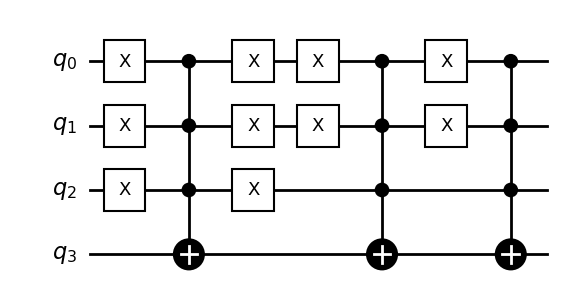

In [88]:
n = 3
set = ['000','001','111']
size_of_set = 3

qr = QuantumRegister(n+1,"q")
qc = QuantumCircuit(qr)

for i in range(size_of_set):
    for k in range(n):
        if int(set[i][k])==0:
            qc.x(qr[k])
        else:
            pass
         
    qc.mcx(qr[:n],qr[n])

    for k in range(n):
        if int(set[i][k])==0:
            qc.x(qr[k])
        else:
            pass
                  

qc.draw("mpl",style="bw")

We can ask for $n$ and the the set $\{x_i\}$ as input (again, in other words, ask for $f$) from the user to output a circuit $U$ satisfying $U|x\rangle_n|0\rangle_1=|x\rangle_n|f(x)\rangle_1$:

In [111]:
set = []

# Get n
n = int(input("Enter n: "))

# Get the number of elements in the set
size = int(input("Enter the number of elements in the set defining f: "))

# Append elements to the list
for i in range(size):
    element = input(f"Enter element {i+1}: ")
    set.append(element)

print("Set:", set)

Enter n:  3
Enter the number of elements in the set defining f:  6
Enter element 1:  000
Enter element 2:  001
Enter element 3:  010
Enter element 4:  100
Enter element 5:  011
Enter element 6:  101


Set: ['000', '001', '010', '100', '011', '101']


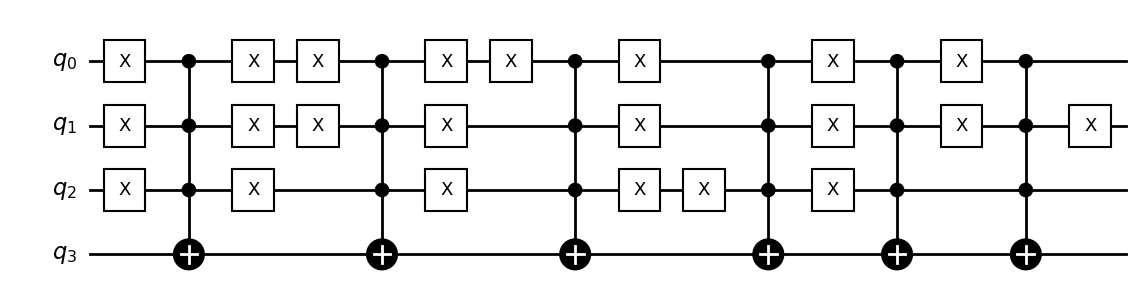

In [113]:
qr = QuantumRegister(n+1,"q")
qc = QuantumCircuit(qr)

for i in range(size):
    for k in range(n):
        if int(set[i][k])==0:
            qc.x(qr[k])
        else:
            pass
         
    qc.mcx(qr[:n],qr[n])

    for k in range(n):
        if int(set[i][k])==0:
            qc.x(qr[k])
        else:
            pass
                  

qc.draw("mpl",style="bw")

Clearly from above, the circuits are not using an optimal amount of gates as we have many instances of $X\circ X$ gates on qubits that cancel and could cost no gates rather than $2$. Let's try to account for this overuse of gates:

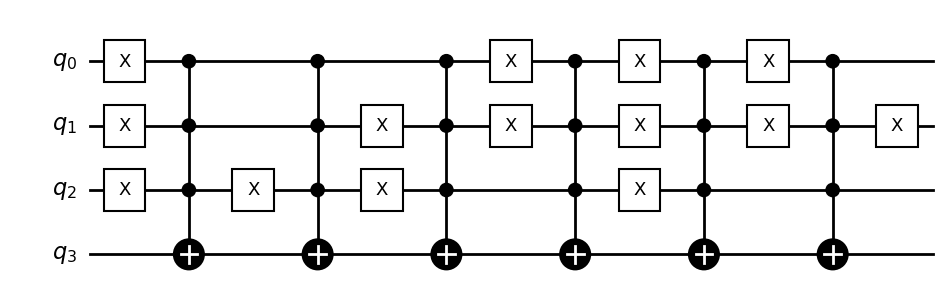

In [115]:
qr = QuantumRegister(n+1,"q")
qc = QuantumCircuit(qr)

for i in range(size):
    if i==0:
        for k in range(n):
            if int(set[i][k])==0:
                qc.x(qr[k])
            else:
                pass
    else:
        for k in range(n):
            if int(set[i][k])==0 and int(set[i-1][k])==1:
                qc.x(qr[k])
            else:
                pass
         
    qc.mcx(qr[:n],qr[n])
    if i==size-1:
        for k in range(n):
            if int(set[i][k])==0:
                qc.x(qr[k])
            else:
                pass
    else:
        for k in range(n):
            if int(set[i][k])==0 and int(set[i+1][k])==1:
                qc.x(qr[k])
            else:
                pass
        
                  

qc.draw("mpl",style="bw")

We see from the new output that our circuit depth for each $f$ should be $2n+1$. Each circuit will use $n$ multi-controlled $X$ gates and $(n+1)$ $X^{\otimes k}$ gates, where $0\leq k\leq n$ depends on the amount of $0$ bits in each $x\in\{x_i\}$.